In [1]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
import random
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

# Importing documents

In [2]:
#Thomas data folder 
# DATA_FOLDER='/Users/thomaspalomares/Desktop/Stanford/RA/multisentences/data/'
#Tanya data folder
# DATA_FOLDER='/Users/tanyaberardini/Desktop/DeepDive/data/'
DATA_FOLDER='arabidopsis_data/'

In [3]:
import json

In [4]:
# #To be modified to conserve correct doc_ids (in particular, write in different txt files)
# nb_lines=0
# nb_error_parsing=0
# with open(DATA_FOLDER+'pmc/json/output_plant.json', 'rb') as json_file:
#     with open(DATA_FOLDER+'pmc/text/output_plant.text', 'wb') as text_write:
#         docs={}
#         for line in json_file:
#             nb_lines+=1
#             doc_id_read=str(json.loads(line)['doc-id'].encode('utf-8').strip())
# #             try:
#             #Because this doc is too big
#             if doc_id_read=='10.1093.jxb.eru198':
#                 if random.random() <0.5:
#                     doc_id_read += '_1'
#                 else:
#                     doc_id_read += '_2'
#             if doc_id_read in docs:
#                 docs[doc_id_read] += unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
#             else:
#                 docs[doc_id_read] = unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
# #                 text_write.write(unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore'))
# #             except:
# #                 nb_error_parsing +=1
# #                 print "error parsing"
# print nb_lines
# print nb_error_parsing

In [5]:
# test = SentenceParser()
# test.parse(docs)
# # dp = DocParser(DATA_FOLDER + 'pmc/text/', TextParser())

In [6]:
pkl_f=DATA_FOLDER+'pmc/pickle/pkl_sentences'
sents=[]
count_loop=0
try:
    with open(pkl_f, 'rb') as f:
        sents = cPickle.load(f)
except:
    print"parsing data"
    for doc_id_loop in docs:
        count_loop+=1
        print count_loop
        for j in test.parse(docs[doc_id_loop], doc_id=doc_id_loop):
            sents.append(j)
    with open(pkl_f, 'w+') as f:
        cPickle.dump(sents, f)

In [8]:
#Think about how to add doc_ids. 
#In particular, look at the small code in parseDocSentences()
# %time sents = dp.parseDocSentences()
# print sents[0]

# Candidate mention Extraction

## Gene extraction

In [9]:
#What is the exact schema of genes ?
genes=[]
for row_genes in [line.rstrip().split('\t') for line in open(DATA_FOLDER + '/dicts/list_genes.txt')]:
    for gene in row_genes:
        genes.append(gene)
        
#Removing blacklist_words
blacklist_words = [line.rstrip().split('\t')[1].lower() for line in open(DATA_FOLDER + '/dicts/blacklist_words.txt')][1:]
genes_filtered = [x.lower() for x in genes if x.lower() not in blacklist_words]

gene_dm = DictionaryMatch(label='GeneName', dictionary=genes_filtered, ignore_case=False)

The dictionary match should provide fairly high recall, but we may still miss some candidates. We know that gene names are named nouns and are often all uppercase. Let's use DDLite's compositional matcher operations to handle this. First, we'll write a matcher to find all nouns using the parts-of-speech tags. Then, we'll use a filter to find uppercase sequences. Finally, we'll use a filter to make sure each match has at least 3 characters. We pass noun_rm to up_rm, and up_rm to the final filter to compose them with each other.

In [10]:
noun_regex = RegexNgramMatch(label='Nouns', regex_pattern=r'[A-Z]?NN[A-Z]?', ignore_case=True, match_attrib='poses')
up_regex = RegexFilterAll(noun_regex, label='Upper', regex_pattern=r'[A-Z]+([0-9]+)?([A-Z]+)?([0-9]+)?$', ignore_case=False, match_attrib='words')
multi_regex = RegexFilterAll(up_regex, label='Multi', regex_pattern=r'[a-z0-9]{3,}', ignore_case=True)

Since we want matches both from the dictionary and the uppercase-noun-phrase-matcher we just built, we'll use the union object to create a matcher for both.

In [11]:
#The previous regexes seem to catch many patterns not wanted (like 'and' or others), let's ignore it for now and we can add it when we'll work on recall
# GM = Union(gene_dm, multi_regex)
GM=gene_dm

## Pheno extraction

In [12]:
# Schema is: HPO_ID | NAME | TYPE (exact, lemma)
phenos_deepdive = [line.rstrip().split('\t')[1] for line in open(DATA_FOLDER + '/dicts/pheno_terms.tsv')]
phenos_arabidopsis = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/list_phenotypes_arabidopsis_filtered.txt')]
phenos_worm_variants = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/worm_variants_unix.txt')]
phenos_all_eq_dict = [pheno.strip() for line in open(DATA_FOLDER + 'dicts/phenotypes_all_eq_dict.txt') for pheno in line.rstrip().split(';')]
phenos_manual = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/phenotypes_manual.txt')]

phenos_tot = phenos_deepdive + phenos_arabidopsis + phenos_worm_variants + phenos_all_eq_dict + phenos_manual

#Removing the phenotypes that are in the blacklist.
blacklist_words = [line.rstrip().split('\t')[1].lower() for line in open(DATA_FOLDER + '/dicts/blacklist_words.txt')][1:]
phenos_tot_filtered = [x.lower() for x in phenos_tot if x.lower() not in blacklist_words]

PM = DictionaryMatch(label='PhenoName', dictionary=phenos_tot_filtered)

# Relation Extraction

For each sentence, we extract a candidate relation for each pair (gene, phenotype) appearing in the sentence.

In [ ]:
R = Relations(sents, GM, PM)

In [14]:
R[0].render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 While _ dpe1 _ mutants also have a mild impairment in the rate of starch degradation , the primary reason for its high amylose content ( over 20 % of granule mass ; see ) is the accumulation of short malto-oligosaccharides , which can act as primers for GBSS activity -LSB- , -RSB- .

In [15]:
# test_sent=9
# for i in range(len(R[test_sent].dep_parents)):
#     print i, R[test_sent].words[i], R[test_sent].dep_parents[i], R[test_sent].poses[i]

In [16]:
# R.dump_candidates('pickle/relations.pkl')

# ddlite Model

We create a ddlite model from the previous candidates, on which we will extract features, define labeling functions and learn a model. 

In [17]:
DDL = DDLiteModel(R)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 25832 features for each of 925 mentions


# Building a gold ground truth

We label here a certain amount of sentences that will allow us to evaluate our model.

In [18]:
#Importing previous mentions labeled
tags_file = DATA_FOLDER + 'tags/tags_fccb81915ae086e3'
first_line=True
tags_list=[]
with open(tags_file, 'rb') as f:
    for line in f:
        if first_line:
            header=line.rstrip().split('\t')
            first_line=False
        else:
            res={}
            for i, item in enumerate(line.rstrip().split('\t')):
                res[header[i]]=item
            res['sent_id']=int(res['sent_id'])
            res['e1_idxs'] = map(int, res['e1_idxs'][1:-1].split(','))
            res['e2_idxs'] = map(int, res['e2_idxs'][1:-1].split(','))
            tags_list.append(res)

In [19]:
print len(tags_list)
print tags_list[0]

200
{'e2_idxs': [7], 'wrong gene': '\\N', 'e1_label': 'GeneName', 'probability': '', 'e2_label': 'PhenoName', 'sent_id': 132, 'multiple mutant': '\\N', 'is_correct': 'false', 'one word phenotype not useful': '\\N', 'words': '["However", ",", "the", "rates", "of", "germination", "and", "cotyledon", "greening", "among", "_", "abi4", "_", ",", "WT", "and", "_", "OE-ABI4", "_", "were", "comparable", "when", "we", "used", "medium", "supplemented", "with", "exogenous", "GA.", "."]', 'wrong phenotype': 'true', 'e1_idxs': [11], 'doc_id': '10.1371.journal.pgen.1003577', 'overlapping gene and phenotype': '\\N', 'ext_id': '430'}


In [20]:
#Finding the index in DDL of our labeled data
def func_DDL_index_with_tag(DDL_var, tag_var):
#     count=0
    for i in range(DDL.num_candidates()):
        if DDL.C[i].doc_id==tag_var['doc_id']:
            if DDL.C[i].sent_id==tag_var['sent_id']:
                if DDL.C[i].e1_idxs==tag_var['e1_idxs']:
                    if DDL.C[i].e2_idxs==tag_var['e2_idxs']:
#                         count+=1
                        return i
    return -1
#     if count >1:
#         print 'WEIRD: more than one element found'

In [21]:
#Creating the corresponding gold file
gold = np.zeros((DDL.num_candidates()))
for i in range(len(tags_list)):
    idx = func_DDL_index_with_tag(DDL, tags_list[i])
    if idx > -1:
        if tags_list[i]['is_correct']=='false':
            gold[np.array([idx])] = np.array([-1.])
        if tags_list[i]['is_correct']=='true':
            gold[np.array([idx])] = np.array([1.])
            
            
DDL.set_gold_labels(gold)
DDL.set_holdout(p=0.8)

../ddlite.py:769: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.validation = h[ : np.floor(p * len(h))]
../ddlite.py:770: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.test = h[np.floor(p * len(h)) : ]


In [22]:
gold

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0

In [23]:
#Yellow: gene. Blue: phenotype
DDL.open_mindtagger(num_sample=200, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


In [24]:
# DDL.add_mindtagger_tags()
# DDL.get_ground_truth()

# Writing labeling functions

We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an Candidate object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

In [25]:
count=0
for relation in R:
    if 'loss' in relation.words:
        count+=1
        if count <10:
            relation.render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 The Arabidopsis _ ss4 _ mutant phenotype is characterised by the loss of starch in younger leaves , and chloroplasts of older leaves contain one large starch granule .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 However , we were not able to obtain double _ mtr4 hen2 _ mutants , signifying that simultaneous loss of both AtMTR4 and HEN2 is lethal .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 However , we were not able to obtain double _ mtr4 hen2 _ mutants , signifying that simultaneous loss of both AtMTR4 and HEN2 is lethal .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 The deleted amino acids belong to the predicted domain with GTPase activity , where the deletion of the conserved Lys362 has been shown to modify the localization of _ FZL _ , with the consequent loss of function of the FZL protein ( ) ; therefore , the molecular alteration found in the _ fzl - _ L_er _ mutant is compatible with the severe phenotype observed .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 It is therefore not surprising that the _ fzl _ mutation in the Columbia ecotype was reported to cause pale leaves and delayed flowering ( ) while it was found that in the L_er _ background the loss of function of the _ FZL _ gene determined a typical LMM phenotype .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 Since FAX1 in _ Arabidopsis _ belongs to a family of seven proteins , the plastid-predicted FAX2 , 3 , and 4 , whose expression is regulated throughout plant development as well ( ) , most likely can bypass the loss of FAX1 function in all tissues and organs , leading to the rather mild overall phenotype of _ fax1 _ knockouts .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 In concert with the results from the porometer measurement , the percentual fresh weight loss of _ max2 _ plants was significantly larger than that of wild-type plants ( FigureB ) , which further indicates a role for MAX2 in stomatal regulation .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 The _ nad2 _ intron 3 splicing defect led to the loss of mitochondrial complex I activity in _ mterf15 _ .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 The _ nad2 _ intron 3 splicing defect led to the loss of mitochondrial complex I activity in _ mterf15 _ .

In [26]:
#Here, idx_mention refers to 0 or 1, whether we consider the gene or phenotype
def post_window(r, idx_mention, key, n=3):
    s = list(r.all_idxs[idx_mention])
    b = len(r.lemmas) - np.max(s)
    s.extend([np.max(s) + i for i in range(1, min(b,n+1))])
    return key in [r.lemmas[i] for i in s]
def pre_window (r, idx_mention, key, n=3):
    s = list(r.all_idxs[idx_mention])
    b = np.min(s)
    s.extend([b - i for i in range(1, min(b,n+1))])
    return key in [r.lemmas[i] for i in s]
def stopper(r, idx_mention, stop):
    return stop in [r.lemmas[i] for i in r.all_idxs[idx_mention]]

#If the word mutation is before gene:
def LF_mutation_gene_t(r):
    if 'mutation' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
        return 1
    else:
        if 'mutant' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
            return 1
        else:
            return 0
#If the word mutation is before pheno:
def LF_mutation_pheno_t(r):
    if 'mutation' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[1]]:
        return 1
    else:
        if 'mutant' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[1]]:
            return 1
        else:
            return 0
#If phenotype just before gene, certainly wrong
def LF_pheno_before_gene_f(r):
    res=False
    for i in r.all_idxs[1]:
        if pre_window(r, 0, r.words[i], n=1):
            res=True
    if res:
        return -1
    else:
        return 0
#If phenotype is only a verb, likely to be false
def LF_pheno_only_verb_f(r):
    if len(r.all_idxs[1])==1 and r.poses[r.all_idxs[1][0]][0:2] == 'VB':
        return -1
    else:
        return 0
#if phenotype only one word, likely to be false (except lethal)
def LF_pheno_only_one_word_f(r):
    if len(r.all_idxs[1])==1 and r.lemmas[r.all_idxs[1][0]] != 'lethal':
        return -1
    else:
        return 0
#if gene and phenotype have words in common, very likely to be false
def LF_gene_pheno_words_in_common_f(r):
    if len([val for val in r.all_idxs[0] if val in r.all_idxs[1]]) >0:
        return -1
    else:
        return 0
#if gfp at the end of a gene, likely to be false
def LF_gene_ends_in_gfp_f(r):
    if len(r.all_idxs[0])==1 and len(r.mention1()[0]) >2 and r.mention1()[0][-3:].lower() == 'gfp':
        return -1
    else:
        return 0
#If double mutant around the gene name, more likely true:
def LF_double_mutant_gene_t(r):
    if (post_window(r, 0, 'double', 3) and post_window(r, 0, 'mutant', 3)) or (pre_window(r, 0, 'double', 3) and pre_window(r, 0, 'mutant', 3)):
        return 1
    else:
        return 0
#If mutant around the gene name, more likely true:
def LF_mutant_gene_t(r):
    if post_window(r, 0, 'mutant', 3) or pre_window(r, 0, 'mutant', 3):
        return 1
    else:
        return 0
#'In WT' is generally not a phenotype
def LF_in_WT_pheno_f(r):
    if len(r.all_idxs[1])==1 and r.words[r.all_idxs[1][0]] == 'WT' and pre_window(r,1, 'in', 1):
        return -1
    else:
        return 0
#If the sentence mentions "loss of [GENE]
def LF_loss_of_gene_t(r):
    if 'loss' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
        return 1
    if post_window(r, 0, 'loss', 3) or pre_window(r, 0, 'loss', 3):
        return 1
    else:
        return 0    
#if the word 'defect' is around the gene
def LF_defect_of_gene_t(r):
    if 'defect' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
        return 1
    if post_window(r, 0, 'defect', 3) or pre_window(r, 0, 'defect', 3):
        return 1
    else:
        return 0  


In [27]:
LFs= [LF_mutation_gene_t, LF_mutation_pheno_t, LF_pheno_before_gene_f, LF_pheno_only_verb_f, LF_pheno_only_one_word_f, LF_gene_pheno_words_in_common_f, LF_gene_ends_in_gfp_f, LF_double_mutant_gene_t, LF_mutant_gene_t, LF_in_WT_pheno_f, LF_loss_of_gene_t, LF_defect_of_gene_t]
DDL.apply_lfs(LFs, clear=True)

### More analysis on the labeling functions

In [28]:
DDL.print_lf_stats()

LF stats on dev set
Coverage:	84.684%
Overlap:	35.627%
Conflict:	23.862%


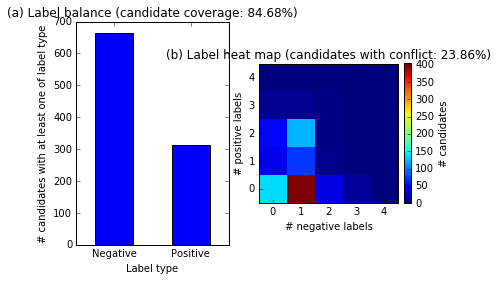

In [29]:
%matplotlib inline
DDL.plot_lf_stats()

In [30]:
DDL.top_conflict_lfs(n=3)

Labeling function,Fraction of candidates where LF has conflict
LF_pheno_only_one_word_f,0.231
LF_mutation_gene_t,0.187
LF_mutant_gene_t,0.183


In [31]:
DDL.lowest_coverage_lfs(n=15)

Labeling function,Fraction of abstained votes
LF_gene_ends_in_gfp_f,1.000
LF_loss_of_gene_t,0.999
LF_defect_of_gene_t,0.997
LF_in_WT_pheno_f,0.989
LF_pheno_only_verb_f,0.989
LF_double_mutant_gene_t,0.987
LF_mutation_pheno_t,0.973
LF_gene_pheno_words_in_common_f,0.962
LF_pheno_before_gene_f,0.954
LF_mutant_gene_t,0.737


In [32]:
DDL.lowest_empirical_accuracy_lfs(n=10)

Labeling function,Empirical LF positive-class accuracy
LF_mutation_gene_t,0.000 (n=0)
LF_pheno_before_gene_f,0.000 (n=0)
LF_gene_pheno_words_in_common_f,0.000 (n=0)
LF_gene_ends_in_gfp_f,0.000 (n=0)
LF_mutant_gene_t,0.000 (n=0)
LF_defect_of_gene_t,0.000 (n=0)
LF_loss_of_gene_t,0.000 (n=0)
LF_mutation_pheno_t,0.000 (n=0)
LF_in_WT_pheno_f,0.000 (n=0)
LF_double_mutant_gene_t,0.000 (n=0)


In [33]:
#Let's have a look at the labeled elements:
DDL.get_labeled_ground_truth(gt='resolve', subset=None)

(array([  8,  10,  54,  81, 173, 178, 182, 200, 232, 260, 297, 341, 438,
        447, 553, 595, 599, 641, 746, 814, 826, 848, 884, 919]),
 array([-1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]))

In [34]:
print DDL.lf_matrix

  (0, 0)	1.0
  (0, 4)	-1.0
  (0, 8)	1.0
  (1, 0)	1.0
  (1, 4)	-1.0
  (1, 8)	1.0
  (2, 4)	-1.0
  (3, 0)	1.0
  (3, 4)	-1.0
  (4, 0)	1.0
  (4, 4)	-1.0
  (4, 7)	1.0
  (4, 8)	1.0
  (5, 4)	-1.0
  (5, 8)	1.0
  (6, 0)	1.0
  (6, 4)	-1.0
  (7, 4)	-1.0
  (9, 4)	-1.0
  (10, 0)	1.0
  (10, 4)	-1.0
  (10, 8)	1.0
  (11, 0)	1.0
  (11, 4)	-1.0
  (11, 8)	1.0
  (13, 0)	1.0
  (13, 4)	-1.0
  (13, 8)	1.0
  (14, 0)	1.0
  (14, 4)	-1.0
  (14, 8)	1.0
  (15, 0)	1.0
  (15, 4)	-1.0
  (15, 8)	1.0
  (16, 2)	-1.0
  (16, 5)	-1.0
  (16, 8)	1.0
  (19, 8)	1.0
  (20, 4)	-1.0
  (21, 0)	1.0
  (21, 4)	-1.0
  (21, 8)	1.0
  (22, 4)	-1.0
  (23, 4)	-1.0
  (24, 4)	-1.0
  (25, 0)	1.0
  (25, 4)	-1.0
  (25, 8)	1.0
  (26, 4)	-1.0
  (26, 8)	1.0
  (27, 4)	-1.0
  (28, 4)	-1.0
  (29, 0)	1.0
  (29, 4)	-1.0
  (29, 8)	1.0
  (30, 4)	-1.0
  (31, 4)	-1.0
  (31, 8)	1.0
  (32, 0)	1.0
  (32, 4)	-1.0
  (32, 8)	1.0
  (33, 4)	-1.0
  (34, 4)	-1.0
  (35, 0)	1.0
  (35, 4)	-1.0
  (35, 8)	1.0
  (36, 0)	1.0
  (36, 4)	-1.0
  (36, 8)	1.0
  (37, 0)	1.0
  (37,

In [35]:
DDL.C[16]

<Relation: [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24] - [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24]>
Words: <Relation: [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24] - [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24]>
Lemmas: <Relation: [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24] - [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24]>
POSES: <Relation: [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24] - [u'early', u'flowering', u'in', u'short', u'days'][20, 21, 22, 23, 24]>

# Learning

In [36]:
matplotlib.rcParams['figure.figsize'] = (12,4)
#Try with bias=True, error currently for some reasons
%time DDL.learn_weights(sample=False, maxIter=1000, alpha=0, bias=False, verbose=True, log=True)

Begin training for mu = 0.0011
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.009626
	Learning epoch = 200	Gradient mag. = 0.009633
	Learning epoch = 300	Gradient mag. = 0.009635
	Learning epoch = 400	Gradient mag. = 0.009636
	Learning epoch = 500	Gradient mag. = 0.009637
	Learning epoch = 600	Gradient mag. = 0.009637
	Learning epoch = 700	Gradient mag. = 0.009637
	Learning epoch = 800	Gradient mag. = 0.009637
	Learning epoch = 900	Gradient mag. = 0.009637
	Learning epoch = 1000	Gradient mag. = 0.009637
	Learning epoch = 1100	Gradient mag. = 0.009637
	Learning epoch = 1200	Gradient mag. = 0.009637
	Learning epoch = 1300	Gradient mag. = 0.009637
	Learning epoch = 1400	Gradient mag. = 0.009637
	Learning epoch = 1500	Gradient mag. = 0.009637
	Learning epoch = 1600	Gradient mag. = 0.009637
	Learning epoch = 1700	Gradient mag. = 0.009637
	Learning epoch = 1800	Gradient mag. = 0.009637
	Learning epoch = 1900	Gradient mag. = 0.009637
	Learning epoch = 200

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.001. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 0.00227605188923
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.009619
	Learning epoch = 200	Gradient mag. = 0.009624
	Learning epoch = 300	Gradient mag. = 0.009625
	Learning epoch = 400	Gradient mag. = 0.009626
	Learning epoch = 500	Gradient mag. = 0.009626
	Learning epoch = 600	Gradient mag. = 0.009626
	Learning epoch = 700	Gradient mag. = 0.009626
	Learning epoch = 800	Gradient mag. = 0.009626
	Learning epoch = 900	Gradient mag. = 0.009626
	Learning epoch = 1000	Gradient mag. = 0.009626
	Learning epoch = 1100	Gradient mag. = 0.009626
	Learning epoch = 1200	Gradient mag. = 0.009626
	Learning epoch = 1300	Gradient mag. = 0.009626
	Learning epoch = 1400	Gradient mag. = 0.009626
	Learning epoch = 1500	Gradient mag. = 0.009626
	Learning epoch = 1600	Gradient mag. = 0.009626
	Learning epoch = 1700	Gradient mag. = 0.009626
	Learning epoch = 1800	Gradient mag. = 0.009626
	Learning epoch = 1900	Gradient mag. = 0.009626
	Learning e

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.002. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


	Learning epoch = 100	Gradient mag. = 0.009606
	Learning epoch = 200	Gradient mag. = 0.009605
	Learning epoch = 300	Gradient mag. = 0.009605
	Learning epoch = 400	Gradient mag. = 0.009605
	Learning epoch = 500	Gradient mag. = 0.009605
	Learning epoch = 600	Gradient mag. = 0.009605
	Learning epoch = 700	Gradient mag. = 0.009605
	Learning epoch = 800	Gradient mag. = 0.009605
	Learning epoch = 900	Gradient mag. = 0.009605
	Learning epoch = 1000	Gradient mag. = 0.009605
	Learning epoch = 1100	Gradient mag. = 0.009605
	Learning epoch = 1200	Gradient mag. = 0.009605
	Learning epoch = 1300	Gradient mag. = 0.009605
	Learning epoch = 1400	Gradient mag. = 0.009605
	Learning epoch = 1500	Gradient mag. = 0.009605
	Learning epoch = 1600	Gradient mag. = 0.009605
	Learning epoch = 1700	Gradient mag. = 0.009605
	Learning epoch = 1800	Gradient mag. = 0.009605
	Learning epoch = 1900	Gradient mag. = 0.009605
	Learning epoch = 2000	Gradient mag. = 0.009605
	Learning epoch = 2100	Gradient mag. = 0.009605
	

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.005. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


	Learning epoch = 100	Gradient mag. = 0.009578
	Learning epoch = 200	Gradient mag. = 0.009567
	Learning epoch = 300	Gradient mag. = 0.009563
	Learning epoch = 400	Gradient mag. = 0.009561
	Learning epoch = 500	Gradient mag. = 0.009561
	Learning epoch = 600	Gradient mag. = 0.009561
	Learning epoch = 700	Gradient mag. = 0.009560
	Learning epoch = 800	Gradient mag. = 0.009560
	Learning epoch = 900	Gradient mag. = 0.009560
	Learning epoch = 1000	Gradient mag. = 0.009560
	Learning epoch = 1100	Gradient mag. = 0.009560
	Learning epoch = 1200	Gradient mag. = 0.009560
	Learning epoch = 1300	Gradient mag. = 0.009560
	Learning epoch = 1400	Gradient mag. = 0.009560
	Learning epoch = 1500	Gradient mag. = 0.009560
	Learning epoch = 1600	Gradient mag. = 0.009560
	Learning epoch = 1700	Gradient mag. = 0.009560
	Learning epoch = 1800	Gradient mag. = 0.009560
	Learning epoch = 1900	Gradient mag. = 0.009560
	Learning epoch = 2000	Gradient mag. = 0.009560
	Learning epoch = 2100	Gradient mag. = 0.009560
	

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.010. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 0.0201627878192
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.009520
	Learning epoch = 200	Gradient mag. = 0.009488
	Learning epoch = 300	Gradient mag. = 0.009476
	Learning epoch = 400	Gradient mag. = 0.009471
	Learning epoch = 500	Gradient mag. = 0.009470
	Learning epoch = 600	Gradient mag. = 0.009469
	Learning epoch = 700	Gradient mag. = 0.009469
	Learning epoch = 800	Gradient mag. = 0.009469
	Learning epoch = 900	Gradient mag. = 0.009469
	Learning epoch = 1000	Gradient mag. = 0.009469
	Learning epoch = 1100	Gradient mag. = 0.009469
	Learning epoch = 1200	Gradient mag. = 0.009469
	Learning epoch = 1300	Gradient mag. = 0.009469
	Learning epoch = 1400	Gradient mag. = 0.009469
	Learning epoch = 1500	Gradient mag. = 0.009469
	Learning epoch = 1600	Gradient mag. = 0.009469
	Learning epoch = 1700	Gradient mag. = 0.009469
	Learning epoch = 1800	Gradient mag. = 0.009469
	Learning epoch = 1900	Gradient mag. = 0.009469
	Learning ep

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.020. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 0.0417195920981
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.009401
	Learning epoch = 200	Gradient mag. = 0.009326
	Learning epoch = 300	Gradient mag. = 0.009298
	Learning epoch = 400	Gradient mag. = 0.009288
	Learning epoch = 500	Gradient mag. = 0.009284
	Learning epoch = 600	Gradient mag. = 0.009283
	Learning epoch = 700	Gradient mag. = 0.009283
	Learning epoch = 800	Gradient mag. = 0.009282
	Learning epoch = 900	Gradient mag. = 0.009282
	Learning epoch = 1000	Gradient mag. = 0.009282
	Learning epoch = 1100	Gradient mag. = 0.009282
	Learning epoch = 1200	Gradient mag. = 0.009282
	Learning epoch = 1300	Gradient mag. = 0.009282
	Learning epoch = 1400	Gradient mag. = 0.009282
	Learning epoch = 1500	Gradient mag. = 0.009282
	Learning epoch = 1600	Gradient mag. = 0.009282
	Learning epoch = 1700	Gradient mag. = 0.009282
	Learning epoch = 1800	Gradient mag. = 0.009282
	Learning epoch = 1900	Gradient mag. = 0.009282
	Learning ep

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.042. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 0.0863235967387
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.009160
	Learning epoch = 200	Gradient mag. = 0.008999
	Learning epoch = 300	Gradient mag. = 0.008940
	Learning epoch = 400	Gradient mag. = 0.008919
	Learning epoch = 500	Gradient mag. = 0.008911
	Learning epoch = 600	Gradient mag. = 0.008909
	Learning epoch = 700	Gradient mag. = 0.008908
	Learning epoch = 800	Gradient mag. = 0.008907
	Learning epoch = 900	Gradient mag. = 0.008907
	Learning epoch = 1000	Gradient mag. = 0.008907
	Learning epoch = 1100	Gradient mag. = 0.008907
	Learning epoch = 1200	Gradient mag. = 0.008907
	Learning epoch = 1300	Gradient mag. = 0.008907
	Learning epoch = 1400	Gradient mag. = 0.008907
	Learning epoch = 1500	Gradient mag. = 0.008907
	Learning epoch = 1600	Gradient mag. = 0.008907
	Learning epoch = 1700	Gradient mag. = 0.008907
	Learning epoch = 1800	Gradient mag. = 0.008907
	Learning epoch = 1900	Gradient mag. = 0.008907
	Learning ep

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.086. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 0.178615441311
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.008679
	Learning epoch = 200	Gradient mag. = 0.008356
	Learning epoch = 300	Gradient mag. = 0.008240
	Learning epoch = 400	Gradient mag. = 0.008198
	Learning epoch = 500	Gradient mag. = 0.008183
	Learning epoch = 600	Gradient mag. = 0.008178
	Learning epoch = 700	Gradient mag. = 0.008176
	Learning epoch = 800	Gradient mag. = 0.008175
	Learning epoch = 900	Gradient mag. = 0.008175
	Learning epoch = 1000	Gradient mag. = 0.008174
	Learning epoch = 1100	Gradient mag. = 0.008174
	Learning epoch = 1200	Gradient mag. = 0.008174
	Learning epoch = 1300	Gradient mag. = 0.008174
	Learning epoch = 1400	Gradient mag. = 0.008174
	Learning epoch = 1500	Gradient mag. = 0.008174
	Learning epoch = 1600	Gradient mag. = 0.008174
	Learning epoch = 1700	Gradient mag. = 0.008174
	Learning epoch = 1800	Gradient mag. = 0.008174
	Learning epoch = 1900	Gradient mag. = 0.008174
	Learning epo

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.179. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 0.369580011491
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.007758
	Learning epoch = 200	Gradient mag. = 0.007159
	Learning epoch = 300	Gradient mag. = 0.006951
	Learning epoch = 400	Gradient mag. = 0.006876
	Learning epoch = 500	Gradient mag. = 0.006849
	Learning epoch = 600	Gradient mag. = 0.006839
	Learning epoch = 700	Gradient mag. = 0.006835
	Learning epoch = 800	Gradient mag. = 0.006834
	Learning epoch = 900	Gradient mag. = 0.006833
	Learning epoch = 1000	Gradient mag. = 0.006833
	Learning epoch = 1100	Gradient mag. = 0.006833
	Learning epoch = 1200	Gradient mag. = 0.006833
	Learning epoch = 1300	Gradient mag. = 0.006833
	Learning epoch = 1400	Gradient mag. = 0.006833
	Learning epoch = 1500	Gradient mag. = 0.006833
	Learning epoch = 1600	Gradient mag. = 0.006833
	Learning epoch = 1700	Gradient mag. = 0.006833
	Learning epoch = 1800	Gradient mag. = 0.006833
	Learning epoch = 1900	Gradient mag. = 0.006833
	Learning epo

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.370. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 0.764712075795
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.006136
	Learning epoch = 200	Gradient mag. = 0.005175
	Learning epoch = 300	Gradient mag. = 0.004861
	Learning epoch = 400	Gradient mag. = 0.004750
	Learning epoch = 500	Gradient mag. = 0.004710
	Learning epoch = 600	Gradient mag. = 0.004696
	Learning epoch = 700	Gradient mag. = 0.004691
	Learning epoch = 800	Gradient mag. = 0.004689
	Learning epoch = 900	Gradient mag. = 0.004688
	Learning epoch = 1000	Gradient mag. = 0.004688
	Learning epoch = 1100	Gradient mag. = 0.004688
	Learning epoch = 1200	Gradient mag. = 0.004687
	Learning epoch = 1300	Gradient mag. = 0.004687
	Learning epoch = 1400	Gradient mag. = 0.004687
	Learning epoch = 1500	Gradient mag. = 0.004687
	Learning epoch = 1600	Gradient mag. = 0.004687
	Learning epoch = 1700	Gradient mag. = 0.004687
	Learning epoch = 1800	Gradient mag. = 0.004687
	Learning epoch = 1900	Gradient mag. = 0.004687
	Learning epo

../ddlite.py:1162: UserWarning: SGD did not converge for mu=0.765. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 1.58229487712
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.003748
	Learning epoch = 200	Gradient mag. = 0.002613
	Learning epoch = 300	Gradient mag. = 0.002288
	Learning epoch = 400	Gradient mag. = 0.002179
	Learning epoch = 500	Gradient mag. = 0.002140
	Learning epoch = 600	Gradient mag. = 0.002127
	Learning epoch = 700	Gradient mag. = 0.002121
	Learning epoch = 800	Gradient mag. = 0.002120
	Learning epoch = 900	Gradient mag. = 0.002119
	Learning epoch = 1000	Gradient mag. = 0.002119
	Learning epoch = 1100	Gradient mag. = 0.002119
	Learning epoch = 1200	Gradient mag. = 0.002119
	Learning epoch = 1300	Gradient mag. = 0.002119
	Learning epoch = 1400	Gradient mag. = 0.002119
	Learning epoch = 1500	Gradient mag. = 0.002119
	Learning epoch = 1600	Gradient mag. = 0.002119
	Learning epoch = 1700	Gradient mag. = 0.002119
	Learning epoch = 1800	Gradient mag. = 0.002119
	Learning epoch = 1900	Gradient mag. = 0.002119
	Learning epoc

../ddlite.py:1162: UserWarning: SGD did not converge for mu=1.582. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 3.27398658579
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.001337
	Learning epoch = 200	Gradient mag. = 0.000629
	Learning epoch = 300	Gradient mag. = 0.000477
	Learning epoch = 400	Gradient mag. = 0.000431
	Learning epoch = 500	Gradient mag. = 0.000415
	Learning epoch = 600	Gradient mag. = 0.000409
	Learning epoch = 700	Gradient mag. = 0.000407
	Learning epoch = 800	Gradient mag. = 0.000406
	Learning epoch = 900	Gradient mag. = 0.000406
	Learning epoch = 1000	Gradient mag. = 0.000406
	Learning epoch = 1100	Gradient mag. = 0.000406
	Learning epoch = 1200	Gradient mag. = 0.000406
	Learning epoch = 1300	Gradient mag. = 0.000406
	Learning epoch = 1400	Gradient mag. = 0.000406
	Learning epoch = 1500	Gradient mag. = 0.000406
	Learning epoch = 1600	Gradient mag. = 0.000406
	Learning epoch = 1700	Gradient mag. = 0.000406
	Learning epoch = 1800	Gradient mag. = 0.000406
	Learning epoch = 1900	Gradient mag. = 0.000406
	Learning epoc

../ddlite.py:1162: UserWarning: SGD did not converge for mu=3.274. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 6.77433032173
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.000162
	Learning epoch = 200	Gradient mag. = 0.000034
	Learning epoch = 300	Gradient mag. = 0.000019
	Learning epoch = 400	Gradient mag. = 0.000016
	Learning epoch = 500	Gradient mag. = 0.000014
	Learning epoch = 600	Gradient mag. = 0.000014
	Learning epoch = 700	Gradient mag. = 0.000014
	Learning epoch = 800	Gradient mag. = 0.000014
	Learning epoch = 900	Gradient mag. = 0.000014
	Learning epoch = 1000	Gradient mag. = 0.000014
	Learning epoch = 1100	Gradient mag. = 0.000014
	Learning epoch = 1200	Gradient mag. = 0.000014
	Learning epoch = 1300	Gradient mag. = 0.000014
	Learning epoch = 1400	Gradient mag. = 0.000014
	Learning epoch = 1500	Gradient mag. = 0.000014
	Learning epoch = 1600	Gradient mag. = 0.000014
	Learning epoch = 1700	Gradient mag. = 0.000014
	Learning epoch = 1800	Gradient mag. = 0.000014
	Learning epoch = 1900	Gradient mag. = 0.000014
	Learning epoc

../ddlite.py:1162: UserWarning: SGD did not converge for mu=6.774. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 14.0170248427
	Learning epoch = 0	Gradient mag. = 0.000000
	Learning epoch = 100	Gradient mag. = 0.000002
	Learning epoch = 200	Gradient mag. = 0.000000
	Learning epoch = 300	Gradient mag. = 0.000000
	Learning epoch = 400	Gradient mag. = 0.000000
	Learning epoch = 500	Gradient mag. = 0.000000
	Learning epoch = 600	Gradient mag. = 0.000000
	Learning epoch = 700	Gradient mag. = 0.000000
	Learning epoch = 800	Gradient mag. = 0.000000
	Learning epoch = 900	Gradient mag. = 0.000000
	Learning epoch = 1000	Gradient mag. = 0.000000
	Learning epoch = 1100	Gradient mag. = 0.000000
	Learning epoch = 1200	Gradient mag. = 0.000000
	Learning epoch = 1300	Gradient mag. = 0.000000
	Learning epoch = 1400	Gradient mag. = 0.000000
	Learning epoch = 1500	Gradient mag. = 0.000000
	Learning epoch = 1600	Gradient mag. = 0.000000
	Learning epoch = 1700	Gradient mag. = 0.000000
	Learning epoch = 1800	Gradient mag. = 0.000000
	Learning epoch = 1900	Gradient mag. = 0.000000
	Learning epoc

../ddlite.py:1162: UserWarning: SGD did not converge for mu=14.017. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


	Learning epoch = 100	Gradient mag. = 0.000000
	Learning epoch = 200	Gradient mag. = 0.000000
	Learning epoch = 300	Gradient mag. = 0.000000
	Learning epoch = 400	Gradient mag. = 0.000000
	Learning epoch = 500	Gradient mag. = 0.000000
	Learning epoch = 600	Gradient mag. = 0.000000
	Learning epoch = 700	Gradient mag. = 0.000000
	Learning epoch = 800	Gradient mag. = 0.000000
	Learning epoch = 900	Gradient mag. = 0.000000
	Learning epoch = 1000	Gradient mag. = 0.000000
	Learning epoch = 1100	Gradient mag. = 0.000000
	Learning epoch = 1200	Gradient mag. = 0.000000
	Learning epoch = 1300	Gradient mag. = 0.000000
	Learning epoch = 1400	Gradient mag. = 0.000000
	Learning epoch = 1500	Gradient mag. = 0.000000
	Learning epoch = 1600	Gradient mag. = 0.000000
	Learning epoch = 1700	Gradient mag. = 0.000000
	Learning epoch = 1800	Gradient mag. = 0.000000
	Learning epoch = 1900	Gradient mag. = 0.000000
	Learning epoch = 2000	Gradient mag. = 0.000000
	Learning epoch = 2100	Gradient mag. = 0.000000
	

../ddlite.py:1162: UserWarning: SGD did not converge for mu=29.003. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Begin training for mu = 60.0115425929
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=60.012 after 87 steps
Begin training for mu = 124.172168085
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=124.172 after 42 steps
Begin training for mu = 256.9293616
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=256.929 after 25 steps
Begin training for mu = 531.622326243
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=531.622 after 17 steps
Begin training for mu = 1100.0
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1100.000 after 12 steps
CPU times: user 2min 28s, sys: 3.55 s, total: 2min 31s
Wall time: 2min 36s


<ddlite.ModelLog instance at 0x12d724b90>

/Users/thomaspalomares/Desktop/Stanford/RA/multisentences/ddlite_forked/.virtualenv/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/thomaspalomares/Desktop/Stanford/RA/multisentences/ddlite_forked/.virtualenv/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


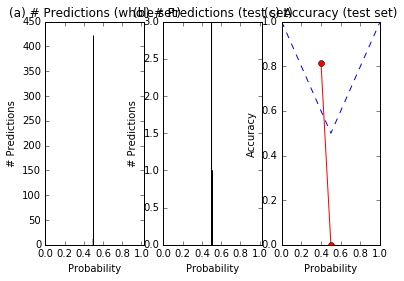

In [37]:
%matplotlib inline
DDL.plot_calibration()

# Iterating with labeling functions

In [38]:
DDL.show_log()

ID,# LFs,# ground truth,Precision,Recall,F1
0,12,5,0.000,0.000,0.000


In [39]:
# DDL.open_mindtagger(width='100%', height=1200)
DDL.open_mindtagger(num_sample=200, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


# Attempt with multi sentences

Here we concatenante 2 sentences in a same document, then export all the relations from this new dataset and keep only the candidates that have a "." between them.

In [92]:
#Function to merge two dependencies path, just a prototype currently, many different possible
#In this function, the "." between the two sentences is placed as the root and the sentences are attached below
def merge_dependency_paths(dep_parent1, dep_parent2):
    res_dep_parents = dep_parent1+dep_parent2
    idx_root_sent1=-1
    for i in range(len(dep_parent1)):
        if dep_parent1[i]==0:
            idx_root_sent1=i
            break
    idx_root_sent2=-1
    for i in range(len(dep_parent2)):
        if dep_parent2[i]==0:
            idx_root_sent2=i
            break
    #Setting the "." between the two sentences as the root
    res_dep_parents[len(dep_parent1)-1]=0
    #Connecting the two previous roots this new root
    res_dep_parents[idx_root_sent1]=len(dep_parent1)
    res_dep_parents[idx_root_sent2]=len(dep_parent1)
    return res_dep_parents


sents_multi = []
for idx in range(len(sents)-1):
    if sents[idx+1].doc_id == sents[idx].doc_id and sents[idx+1].sent_id == sents[idx].sent_id+1:
        parts = defaultdict(list)
        parts['words']=(sents[idx].words+sents[idx+1].words)
        parts['lemmas']=(sents[idx].lemmas+sents[idx+1].lemmas)
        parts['poses']=(sents[idx].poses+sents[idx+1].poses)
        parts['token_idxs']=(sents[idx].token_idxs+sents[idx+1].token_idxs)
        parts['dep_labels']=(sents[idx].dep_labels+sents[idx+1].dep_labels)
        parts['sent_id']=(sents[idx].sent_id)
        parts['doc_id']=(sents[idx].doc_id)
        parts['text']=(sents[idx].text+' '+ sents[idx+1].text)
        parts['dep_parents']=(merge_dependency_paths(sents[idx].dep_parents, sents[idx+1].dep_parents))
        res_sent = Sentence(**parts)
        sents_multi.append(res_sent)

In [93]:
print sents[0].words + sents[1].words
print ' '
print sents_multi[0]

[u'PROTEIN', u'TARGETING', u'TO', u'STARCH', u'Is', u'Required', u'for', u'Localising', u'GRANULE-BOUND', u'STARCH', u'SYNTHASE', u'to', u'Starch', u'Granules', u'and', u'for', u'Normal', u'Amylose', u'Synthesis', u'in', u'Arabidopsis', u'.', u'It', u'Takes', u'Two', u'to', u'Tango', u':', u'A', u'New', u'Partner', u'in', u'Amylose', u'Synthesis', u'.']
 
Sentence(words=[u'PROTEIN', u'TARGETING', u'TO', u'STARCH', u'Is', u'Required', u'for', u'Localising', u'GRANULE-BOUND', u'STARCH', u'SYNTHASE', u'to', u'Starch', u'Granules', u'and', u'for', u'Normal', u'Amylose', u'Synthesis', u'in', u'Arabidopsis', u'.', u'It', u'Takes', u'Two', u'to', u'Tango', u':', u'A', u'New', u'Partner', u'in', u'Amylose', u'Synthesis', u'.'], lemmas=[u'PROTEIN', u'TARGETING', u'to', u'STARCH', u'be', u'require', u'for', u'localise', u'granule-bound', u'starch', u'synthase', u'to', u'Starch', u'Granules', u'and', u'for', u'normal', u'Amylose', u'synthesis', u'in', u'Arabidopsis', u'.', u'it', u'take', u'two',

In [94]:
R_multi = Relations(sents_multi, GM, PM)

In [97]:
R_multi[0].render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 DPE1 is a glucanotransferase involved in plastidial malto-oligosaccaharide metabolism during starch degradation . While _ dpe1 _ mutants also have a mild impairment in the rate of starch degradation , the primary reason for its high amylose content ( over 20 % of granule mass ; see ) is the accumulation of short malto-oligosaccharides , which can act as primers for GBSS activity -LSB- , -RSB- .

First basic version when some end of sentences "." are replaced by ";" to easily have candidates covered in multisentences.

In [40]:
# #To be modified to conserve correct doc_ids (in particular, write in different txt files)
# nb_lines=0
# nb_error_parsing=0
# with open(DATA_FOLDER+'pmc/json/output_plant.json', 'rb') as json_file:
#     with open(DATA_FOLDER+'pmc/text/output_plant.text', 'wb') as text_write:
#         docs_multisentences={}
#         for line in json_file:
#             nb_lines+=1
#             doc_id_read=str(json.loads(line)['doc-id'].encode('utf-8').strip())
# #             try:
#             #Because this doc is too big
#             if doc_id_read=='10.1093.jxb.eru198':
#                 if random.random() <0.5:
#                     doc_id_read += '_1'
#                 else:
#                     doc_id_read += '_2'
#             if doc_id_read in docs_multisentences:
#                 if random.random() < 0.5:
#                     docs_multisentences[doc_id_read] += unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
#                 else:
#                     docs_multisentences[doc_id_read] += unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + ';\n', errors='ignore')
#             else:            
#                 if random.random() < 0.5:
#                     docs_multisentences[doc_id_read] = unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
#                 else:
#                     docs_multisentences[doc_id_read] = unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + ';\n', errors='ignore') 

                    
# print nb_lines
# print nb_error_parsing

In [41]:
# pkl_f=DATA_FOLDER+'pmc/pickle/pkl_sentences_multi'
# sents_multi=[]
# count_loop=0
# try:
#     with open(pkl_f, 'rb') as f:
#         sents_multi = cPickle.load(f)
# except:
#     print"parsing data"
#     for doc_id_loop in docs:
#         count_loop+=1
#         print count_loop
#         for j in test.parse(docs_multisentences[doc_id_loop], doc_id=doc_id_loop):
#             sents_multi.append(j)
#     with open(pkl_f, 'w+') as f:
#         cPickle.dump(sents_multi, f)

In [42]:
# print sents_multi[0]

In [43]:
# R_multi = Relations(sents_multi, GM, PM)

In [44]:
# DDL_multi = DDLiteModel(R_multi)
# print "Extracted {} features for each of {} mentions".format(DDL_multi.num_feats(), DDL_multi.num_candidates())

In [45]:
# DDL_multi.open_mindtagger(num_sample=200, width='100%', height=1200)